@Abdulrahman Alabrash 

https://github.com/alabrashJr/DCNN-Julia


Read data from saved file 
load("TREC_sib.jld2","datas")-> returns revs, W, W2, word_idx_map, vocab
* revs Dict{String,Any} with 5 entries:y,num_words,tree,text,split
    * y-> label of the questions 1-5 
    * num_words-> length of questions 
    * tree -> 46-element Array{Array,1}, each array contains data_sibling(5)+data_tree(5) =10
    * text -> the question text 
    * split -> type of tuple (training, test , div)



* W wordembedding generated by google2vec, size(10098×300)
* W2 word embedding generated by -0.25 , 0.25 size(10098×300)
* word_idx_map Dict{Any,Any} with 10097 entries , unique word id dictionary 
* vocab DefaultDict{Any,Any,Int64} with 10097 entries, vocab and reptation dictionary

In [1]:
using Pkg;Pkg.update(); for p in ("Embeddings","DataFrames","DataStructures","DataFrames","FileIO","LinearAlgebra","Knet","FileIO"); haskey(Pkg.installed(),p) || Pkg.add(p); end
using DataStructures,DataFrames,FileIO,Embeddings,LinearAlgebra,DataFrames;
using Base.Iterators: flatten
using Statistics: mean
using Knet: Knet, conv4, pool, mat, KnetArray, nll, zeroone, progress, sgd, param, param0, dropout, relu, Data,minibatch;
using Dates

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
 Resolving package versions...
  Updating `~/.julia/environments/v1.1/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.1/Manifest.toml`
 [no changes]


┌ Info: Precompiling DataFrames [a93c6f00-e57d-5684-b7b6-d8193f3e46c0]
└ @ Base loading.jl:1186


In [2]:
labels=["abbreviation", "entity", "description", "location" ,"numeric"," "]
revs, W, W2, word_idx_map, vocab=load("Data/TREC_sib.jld2","datas"); 
word_idx_map["ROOT"]=size(W,1);
W=W';

In [3]:
#change W2 with prof's method 
# struct Embed; w; end
# Embed(vocabsize::Int,embedsize::Int) = Embed(param(embedsize,vocabsize))
# (e::Embed)(x) = e.w[:,x]
# W2=Embed(300,length(vocab))

In [4]:
#Transforms sentence into a list of indices. Pad with zeroes.
function get_text_mat(t,word_idx_map;max_l=56,filter_h=5)
    #t the text of question
    x=[] # output matrix
    pad=filter_h -1 # padding number
    for i in collect(1:pad);push!(x,0);end #adding padding 
    words=split(t)
    #extract the unique id of words in the question text and adding it to the matrix 
    for w in words
        if w in keys(word_idx_map);push!(x,word_idx_map[w])
        else; @show w ;end
    end    

    while length(x)<max_l+2*pad    # accomplish 64 +1 size by adding zeros till finish 
            push!(x,0)
    end
    
    return  x
end

get_text_mat (generic function with 1 method)

In [5]:
function getSen(vector)
#labels=["abbreviation","numeric",  "description", "human","location" ,"entity"]
t=Array{Int}(vector)
println(permutedims(t))
for i in t
    if i==1557;print("?\n y =",t[end]+1 );break;end
    if i==0;continue;end
    for (key,value) in word_idx_map
        if value==i; print(key," ");end
    end
end
end

getSen (generic function with 1 method)

In [6]:
#Transforms sentence into a list of indices. Pad with zeroes. 
function get_tree_rep(r,word_idx_map)
# question 
#@show t=r["tree"] #the tree of question
    each_sent=deepcopy(r)# output matrix
    for (j, each_word) in enumerate(each_sent[1:end-1])
        #@show (j, each_word)
            for (l, each_field) in enumerate(each_word)
           # @show (l, each_field)
                if each_field in keys( word_idx_map)
                #@show j,l ;
                    each_sent[j]=Array{Any,1}(each_sent[j])
                     each_sent[j][l] = word_idx_map[each_field]
                elseif each_field == 0
                    continue
                else
                    @show each_field
                end
            end
    end       
    return each_sent;
end

get_tree_rep (generic function with 1 method)

In [7]:
ran=rand(1:length(revs));@show ran
print(revs[ran]["text"]); println("\t",length(split(revs[ran]["text"])))
println(permutedims(get_text_mat(revs[ran]["text"],word_idx_map;max_l=56) ))
for i in split(revs[ran]["text"]) ;println(i,"=",word_idx_map[i]) ;end

ran = 3885
How do companies cut paper so thin ?	8
Any[0 0 0 0 2939 7204 7685 1767 3947 2670 8296 1557 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
How=2939
do=7204
companies=7685
cut=1767
paper=3947
so=2670
thin=8296
?=1557


In [8]:
tree_ind=1
println(revs[ran]["tree"][tree_ind])
println(permutedims(get_tree_rep(revs[ran]["tree"],word_idx_map))[tree_ind])
for i in revs[ran]["tree"][tree_ind] ;println(i,"=",word_idx_map[i]) ;end

Any["ROOT", "ROOT", "ROOT", "thin", "paper", "thin", "paper", "*STOP*", "*STOP*", "cut"]
Any[10098, 10098, 10098, 8296, 3947, 8296, 3947, 4856, 4856, 1767]
ROOT=10098
ROOT=10098
ROOT=10098
thin=8296
paper=3947
thin=8296
paper=3947
*STOP*=4856
*STOP*=4856
cut=1767


In [9]:
#sample (sentences) trees meraged  
permutedims(vcat(revs[1]["tree"][1:end-1]...))

1×450 Array{Any,2}:
 "ROOT"  "ROOT"  "ROOT"  "did"  "develop"  …  "*ZERO*"  "*ZERO*"  "*ZERO*"

In [10]:
function train_dev_test(revs)
    s1,s2,s3=[],[],[]
    t1,t2,t3=[],[],[]
    for rev in revs
    sent =get_text_mat(rev["text"], word_idx_map)   
    push!(sent,rev["y"])
    sent_tensor = get_tree_rep(rev["tree"], word_idx_map)
        
    if rev["split"]==1
            push!(s1,Array{Int}(sent))
            push!(t1,sent_tensor)
    elseif rev["split"]==2
            push!(s2,Array{Int}(sent))
            push!(t2,sent_tensor)
    elseif rev["split"]==3
            push!(s3,Array{Int}(sent))
            push!(t3,sent_tensor)
    end
end

    train = hcat([f1 for f1 in s1]...)
    test =hcat([f1 for f1 in s2]...)
    dev = hcat([f1 for f1 in s3]...)
    train_tensor = t1
    test_tensor = t2
    dev_tensor = t3
    return (train,test,dev),(train_tensor,test_tensor,dev_tensor)
end
dataset,datasetTensor=train_dev_test(revs);


In [11]:
#try on some vectors 
ran=rand(1:size(dataset[1],2))
getSen(dataset[1][:,ran])

[0 0 0 0 9972 6301 4486 9555 8453 8682 7071 1557 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
Rotary engines were manufactured by which company ?
 y =4

dataset[1] --> train 65×5452 } text data
dataset[2]----> test 65×500  }
dataset[3] ----> dev 0x0     }

datasetTensor[1] ---> train_tensor 5452(46(10)))
datasetTensor[2] ---> test_tensor 500(46(10)))
datasetTensor[3] --->dev_tensor 0(0(0))

In [12]:
#merage each sentecne's words trees(sibling+ancators) together
sent1=vcat([permutedims(vcat(datasetTensor[1][x][1:end-1]...)) for x in 1:size(datasetTensor[1],1)]);#sent1=vcat([permutedims(vcat(datasetTensor[1][1][1:end-1]...)) for x in 1:size(datasetTensor[1],1)]...)
sent2=vcat([permutedims(vcat(datasetTensor[2][x][1:end-1]...)) for x in 1:size(datasetTensor[2],1)]);#sent1=vcat([permutedims(vcat(datasetTensor[1][1][1:end-1]...)) for x in 1:size(datasetTensor[1],1)]...);
#sent1=vcat([permutedims(vcat(datasetTensor[1][1][1:end-1]...)) for x in 1:size(datasetTensor[1],1)]...)'
size(sent1)

(5451,)

In [13]:
#get y 
y_train=Array{Int8}([dataset[1][:,x][end] for x in 1:size(dataset[1],2)]);#ytrainT=[datasetTensor[1][x,:][end][end][end] for x in 1:size(datasetTensor[1],1)];
y_test=Array{Int8}([dataset[2][:,x][end] for x in 1:size(dataset[2],2)]);#ytestT=[datasetTensor[2][x,:][end][end][end] for x in 1:size(datasetTensor[2],1)];

y_train=y_train.+1;
y_test=y_test.+1;



In [14]:
Set(y_train)

Set([5, 2, 6, 4, 1, 3])

In [15]:
Set(y_test)

Set([2, 4, 5, 1, 3, 6])

In [16]:
size(sent1),size(y_train),size(W)

((5451,), (5451,), (300, 10098))

In [17]:
#minibatching
dtrn=minibatch(sent1,y_train,160,shuffle=true);
dtst=minibatch(sent2,y_test,160);
#summary.(Iterators.first(dtrn))
# (x,y) = first(dtrn)
# println.(summary.(x));
summary.(Iterators.first(dtrn))

("160-element Array{Array{Any,2},1}", "160-element Array{Int64,1}")

In [18]:
# Define a convolutional layer:
struct Conv; w; b; f; p;E; end
function (c::Conv)(x) 
#     println("\nConvdeyim \t", typeof(x),"\t", summary(x) )
    #xx=KnetArray{Float32}(reshape(c.E[:, permutedims(hcat(x...))],(300,450,1,160)))
    return c.f.(pool(conv4(c.w, dropout(x,c.p)) .+ c.b))
end
Conv(w1::Int,w2::Int,cx::Int,cy::Int,f=relu;pdrop=0,E=W) = Conv(param(w1,w2,cx,cy), param0(1,1,cy,1), f, pdrop,E)

Conv

In [19]:
# Redefine dense layer (See mlp.ipynb):
struct Dense; w; b; f; p; end
function (d::Dense)(x) 
#     println("\nDensedeyim ,\t " , typeof(x),"\t", summary(x))
    d.f.(d.w * mat(dropout(x,d.p)) .+ d.b) # mat reshapes 4-D tensor to 2-D matrix so we can use matmul
end
Dense(i::Int,o::Int,f=relu;pdrop=0) = Dense(param(o,i), param0(o), f, pdrop)

Dense

In [20]:
# Let's define a chain of layers

struct Chain
    layers
    Chain(layers...) = new(layers)
end
function (c::Chain)(x)
    #println(Dates.format(now(), "MM:SS"),".Chaindeyim\t",summary(x),"\t",size(x))
    x=KnetArray{Float32}(reshape(W[:, permutedims(hcat(x...))],(300,450,1,160)))
    #println(Dates.format(now(), "MM:SS"),".Chaindeyim\t",summary(x),"\t",size(x))
#     println("\nChaindeyim ,\t ", typeof(x),"\t", summary(x))
    (for l in c.layers; x = l(x); end; x)
end
function (c::Chain)(x,y) 
#     println("\nloss Chaindeyim x ,\t ", typeof(x),"\t", summary(x))
#     println("\nloss Chaindeyim y ,\t ", typeof(y),"\t", summary(y))
    nll(c(x),y)
    
end
(c::Chain)(d::Data) = mean(c(x,y) for (x,y) in d)

In [21]:
# hidden_units=[100,2] #which meaning ...... how many conv layers 
# dropout_rate=[0.5] #where in which layer ? conv or dense
n_epochs=50;
# batch_size=170, 
lr_decay = 0.95
function trainresults(file,model; o...)
        println("lr =",lr_decay," \t n_epochs= ",n_epochs)
    if (print("Train from scratch? "); readline()[1]=='y')
        takeevery(n,itr) = (x for (i,x) in enumerate(itr) if i % n == 1)
        r = ((model(dtrn), model(dtst), zeroone(model,dtrn), zeroone(model,dtst))
             for x in takeevery(length(dtrn), progress(sgd(model,repeat(dtrn,n_epochs),lr=lr_decay))))
        r = reshape(collect(Float32,flatten(r)),(4,:))
        Knet.save(file,"results",r)
        Knet.gc() # To save gpu memory
    else
        if isfile(file);r=Knet.load(file,"results");else;println("there is no file such this");return;end
    end
    println(minimum(r,dims=2))
    return r
end

trainresults (generic function with 1 method)

In [22]:
dcnn =   Chain( Conv(3,3,1,1), 
                Conv(4,4,1,1),
                Conv(5,5,1,1),
                Dense(1802,1100,pdrop=0.5), 
                Dense(1100,6,pdrop=0.5))
summary.(l.w for l in dcnn.layers)

#                                                           y                 parameter                 memory
                                                                                                            
#input=300×450                                                                                       300x450
#x1=300-3+1= 298/2 =149 ,y1= 450-3+1= /2 =  224   => y(149,224,1)              3x3x1x5               149x224x5
#x2=149-4+1= 146/2 =73  ,y2= 224-4+1= /2=  110   => y(73,110,1)               4x4x5x10              73x110x10
#x3=73-5+1=  69/2  =34  ,y2= 110-5+1= /2=  53    => y(34,53,1)                5x5x10x10             34x53x10
#fc=34*53*10= 1.802                                                           5x5x10x18020           18.020
#fc=1100x6=6600                                                                18020x1100              6600

# Sum                                                                         ------------          ------------
# #float variable                                                                                    424.820 x4
#Byte                                                                                               =1.699.280
#Batch memory B=160                                                                                 =271.884.800
#consider add more dense layer, decide on where the dropout should be 

5-element Array{String,1}:
 "3×3×1×1 AutoGrad.Param{KnetArray{Float32,4}}"  
 "4×4×1×1 AutoGrad.Param{KnetArray{Float32,4}}"  
 "5×5×1×1 AutoGrad.Param{KnetArray{Float32,4}}"  
 "1100×1802 AutoGrad.Param{KnetArray{Float32,2}}"
 "6×1100 AutoGrad.Param{KnetArray{Float32,2}}"   

In [40]:
cnn = trainresults("models/dcnn.jld2", dcnn);#20ep n_epochs=50;lr_decay = 0.95

1.74e+00  100.00%┣███████████████████████████████┫ 680/680 [56:17/56:17, 4.97s/i]
Float32[1.71675; 1.74754; 0.770404; 0.68125]


In [29]:
cnn = trainresults("models/dcnn.jld2", dcnn);#20ep n_epochs=50;lr_decay = 0.95

lr =0.01 	 n_epochs= 100
Train from scratch? stdin> n
Float32[1.71675; 1.74754; 0.770404; 0.68125]


4×20 Array{Float32,2}:
 1.78895   1.72384   1.71935   1.71816   …  1.71675   1.71727  1.71719 
 1.78749   1.75539   1.75538   1.75369      1.74754   1.74917  1.75559 
 0.778493  0.770588  0.775368  0.775735     0.770588  0.77114  0.770404
 0.68125   0.81875   0.866667  0.866667     0.81875   0.81875  0.81875 

In [31]:
dcnn2 =   Chain( Conv(3,3,1,5), 
                Conv(4,4,5,10),
                Conv(5,5,10,15),
                Dense(27030,1100,pdrop=0.5), 
                Dense(1100,6,pdrop=0.5))
summary.(l.w for l in dcnn2.layers)

#                                                           y                 parameter                 memory
                                                                                                            
#input=300×450                                                                                       300x450
#x1=300-3+1= 298/2 =149 ,y1= 450-3+1= /2 =  224   => y(149,224,10)              3x3x1x5               149x224x5
#x2=149-4+1= 146/2 =73  ,y2= 224-4+1= /2=  110   => y(73,110,20)               4x4x5x10              73x110x10
#x3=73-5+1=  69/2  =34  ,y2= 110-5+1= /2=  53    => y(34,53,30)                5x5x10x10             34x53x10
#fc=34*53*15= 27.030                                                         5x5x10x18020           18.020
#fc=1100x6=6600                                                                18020x1100              6600

# Sum                                                                         ------------          ------------
# #float variable                                                                                    424.820 x4
#Byte                                                                                               =1.699.280
#Batch memory B=160                                                                                 =271.884.800
#consider add more dense layer, decide on where the dropout should be 

5-element Array{String,1}:
 "3×3×1×5 AutoGrad.Param{KnetArray{Float32,4}}"   
 "4×4×5×10 AutoGrad.Param{KnetArray{Float32,4}}"  
 "5×5×10×15 AutoGrad.Param{KnetArray{Float32,4}}" 
 "1100×27030 AutoGrad.Param{KnetArray{Float32,2}}"
 "6×1100 AutoGrad.Param{KnetArray{Float32,2}}"    

In [56]:
cnn2 = trainresults("model/dcnn2_1.jld2", dcnn2);#20 ,lr_decay = 0.95

1.77e+00  100.00%┣███████████████████████████████┫ 680/680 [57:33/57:33, 5.08s/i]
Float32[1.75345; 1.80363; 0.770588; 0.722917]


In [61]:
cnn3=trainresults("models/dcnn2.jld2", dcnn2);#50 epo,lr_decay = 0.95

1.73e+00  100.00%┣██████████████████████▉┫ 1700/1700 [02:26:53/02:26:53, 5.18s/i]
Float32[1.75325; 1.81384; 0.770404; 0.81875]


In [33]:
cnn3=trainresults("models/dcnn2.jld2", dcnn2);#50 epo,lr_decay = 0.95

lr =0.01 	 n_epochs= 100
Train from scratch? stdin> n
Float32[1.75325; 1.81384; 0.770404; 0.81875]


In [66]:
n_epochs=50;
# batch_size=170, 
lr_decay = 0.15
cnn4=trainresults("models/dcnn2_3.jld2", dcnn2);#50 epo,lr_decay = 0.95 
#1,73

lr =0.15 	 n_epochs= 50
1.76e+00  100.00%┣██████████████████████▉┫ 1700/1700 [02:26:09/02:26:09, 5.16s/i]
Float32[1.75329; 1.81077; 0.770404; 0.81875]


In [34]:
n_epochs=50;
# batch_size=170, 
lr_decay = 0.15
cnn4=trainresults("models/dcnn2_3.jld2", dcnn2);#50 epo,lr_decay = 0.95 
#1,73

lr =0.15 	 n_epochs= 50
Train from scratch? stdin> n
Float32[1.75329; 1.81077; 0.770404; 0.81875]


In [67]:
n_epochs=50;
lr_decay = 0.001
cnn5=trainresults("models/dcnn2_4.jld2", dcnn2);#50 epo,lr_decay = 0.95

lr =0.001 	 n_epochs= 50
1.75e+00  100.00%┣██████████████████████▉┫ 1700/1700 [02:24:26/02:24:26, 5.10s/i]
Float32[1.75301; 1.80942; 0.770404; 0.81875]


In [35]:
n_epochs=50;
lr_decay = 0.001
cnn5=trainresults("models/dcnn2_4.jld2", dcnn2);#50 epo,lr_decay = 0.95

lr =0.001 	 n_epochs= 50
Train from scratch? stdin> n
Float32[1.75301; 1.80942; 0.770404; 0.81875]


In [37]:
dcnn3 =   Chain( Conv(3,3,1,5), 
                Conv(4,4,5,10),
                Conv(5,5,10,15),
                Dense(27030,1100), 
                Dense(1100,6))
summary.(l.w for l in dcnn3.layers)

#                                                           y                 parameter                 memory
                                                                                                            
#input=300×450                                                                                       300x450
#x1=300-3+1= 298/2 =149 ,y1= 450-3+1= /2 =  224   => y(149,224,10)              3x3x1x5               149x224x5
#x2=149-4+1= 146/2 =73  ,y2= 224-4+1= /2=  110   => y(73,110,20)               4x4x5x10              73x110x10
#x3=73-5+1=  69/2  =34  ,y2= 110-5+1= /2=  53    => y(34,53,30)                5x5x10x10             34x53x10
#fc=34*53*15= 27.030                                                         5x5x10x18020           18.020
#fc=1100x6=6600                                                                18020x1100              6600

# Sum                                                                         ------------          ------------
# #float variable                                                                                    424.820 x4
#Byte                                                                                               =1.699.280
#Batch memory B=160                                                                                 =271.884.800
#consider add more dense layer, decide on where the dropout should be 

5-element Array{String,1}:
 "3×3×1×5 AutoGrad.Param{KnetArray{Float32,4}}"   
 "4×4×5×10 AutoGrad.Param{KnetArray{Float32,4}}"  
 "5×5×10×15 AutoGrad.Param{KnetArray{Float32,4}}" 
 "1100×27030 AutoGrad.Param{KnetArray{Float32,2}}"
 "6×1100 AutoGrad.Param{KnetArray{Float32,2}}"    

In [38]:
n_epochs=50;
lr_decay = 0.01
cnn6=trainresults("models/dcnn3.jld2", dcnn3);

lr =0.01 	 n_epochs= 50
Train from scratch? stdin> n
Float32[1.73243; 1.76418; 0.770404; 0.81875]


In [79]:
n_epochs=100;
lr_decay = 0.01
cnn7=trainresults("models/dcnn3_2.jld2", dcnn3);

lr =0.01 	 n_epochs= 100
Train from scratch? stdin> y
1.67e+00  100.00%┣██████████████████████▉┫ 3400/3400 [04:50:37/04:50:37, 5.13s/i]
Float32[1.7107; 1.74035; 0.649265; 0.533333]


In [39]:
n_epochs=100;
lr_decay = 0.01
cnn7=trainresults("models/dcnn3_2.jld2", dcnn3);

lr =0.01 	 n_epochs= 100
Train from scratch? stdin> n
Float32[1.7107; 1.74035; 0.649265; 0.533333]


In [41]:
using Plots; default(fmt=:png,ls=:auto)

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1186


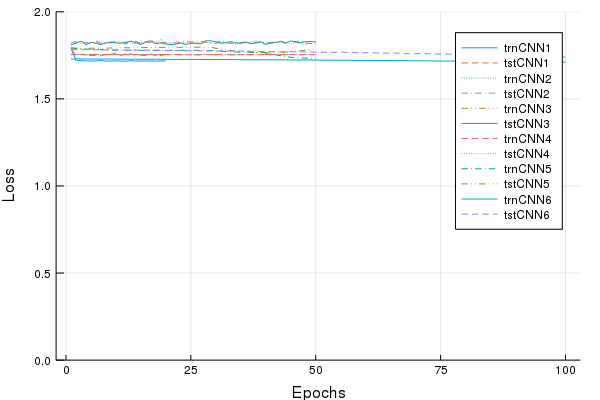

In [42]:
# Comparison to MLP shows faster convergence, better generalization
lines=[cnn[1,:],cnn[2,:],cnn3[1,:], cnn3[2,:],cnn4[1,:], cnn4[2,:],cnn5[1,:], cnn5[2,:],cnn6[1,:], cnn6[2,:],cnn7[1,:], cnn7[2,:]]
la=[:trnCNN1 :tstCNN1 :trnCNN2 :tstCNN2 :trnCNN3 :tstCNN3 :trnCNN4  :tstCNN4 :trnCNN5 :tstCNN5 :trnCNN6 :tstCNN6 :trnCNN7 :tstCNN7]
plot(lines,ylim=(0.0,2),
     labels=la,xlabel="Epochs",ylabel="Loss")  

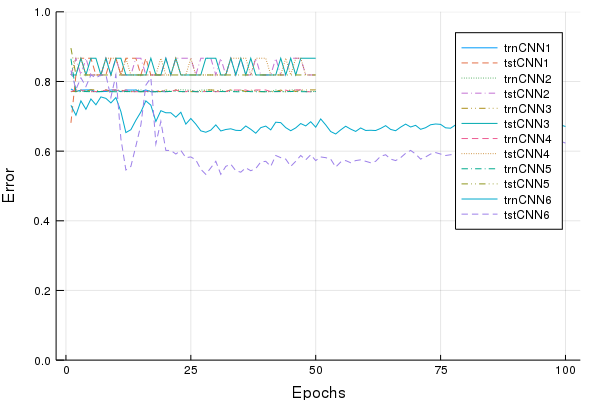

In [43]:
lines2=[cnn[3,:],cnn[4,:],cnn3[3,:], cnn3[4,:],cnn4[3,:], cnn4[4,:],cnn5[3,:], cnn5[4,:],cnn6[3,:], cnn6[4,:],cnn7[3,:], cnn7[4,:]]
plot(lines2,ylim=(0.0,1),
    labels=la,xlabel="Epochs",ylabel="Error")  



In [ ]:
dcnn4 =   Chain( Conv(3,3,1,5), 
                Conv(4,4,5,10),
                Conv(5,5,10,15),
                Dense(27030,1100,pdrop=0.5), 
                Dense(1100,6))
summary.(l.w for l in dcnn4.layers)
n_epochs=200;
lr_decay = 0.005
cnn8=trainresults("models/dcnn4.jld2", dcnn4);

lr =0.005 	 n_epochs= 200
Train from scratch? stdin> y
1.75e+00  0.85%┣▎                             ┫ 58/6800 [05:42/11:08:48, 5.90s/i]

In [ ]:
# Comparison to MLP shows faster convergence, better generalization
lines=[cnn8[1,:],cnn8[2,:]]
la=[:trnCNN8 :tstCNN8 ]
plot(lines,ylim=(0.0,2),
     labels=la,xlabel="Epochs",ylabel="Loss")  

In [ ]:
lines2=[cnn8[3,:],cnn8[4,:]]
plot(lines2,ylim=(0.0,1),
    labels=la,xlabel="Epochs",ylabel="Error")  
